<h1 style="font-size: 3em; text-align: center">Graphs for Trends Reports </h1>


### This notebook explores the different types of graphs we may include in our reports web app.

## Define Metrics & Periods & Bins

### Indicators

`indicators = ["nr_of_sales", "sales_volume", "median_sales_price", "average_sales_price"]`

### Locations
`locations = ["by_parish", "by_region", "all"]`

`by_region` Corresponds to `West`, `Central`, `East`

### Type

`property_type = ["house", "condo", "apartment", "commercial", "land", "fractional", "all"]`


### Time Bins

- **yearly**: show data in `2018, 2019, 2020, 2021, 2022 ...` (being able to select range of years)

- **quarterly**: show data in `2021Q1, 2021Q2, 2021Q3, 2021Q4, 2022Q1, 2022Q2, ... ` (selecting range of years)

- **year_to_date**: show metric in interval `"Jan 1st" -> "Today"`

- **year_over_year**: `(current_year - previous_year)/previous_year`
  for example:
         (Sales20 - Sales21)/Sales21 | (Sales21 - Sales22)/Sales22
 
- **quarter_to_quarter**: `(current_quarter_22 - previous_quarter_22)/previous_quarter_22`
  for example: 
        (Q2-Q1)/Q1 | (Q3-Q2)/Q2 | (Q4-Q3)/Q3
  
  
- **quarter_over_quarter**: `(Qi_year/Qi_previous_year)` (selecting the range of years) 
  for example: 
        (Q1-21/Q1-20) | Q2-21/Q2-20) | (Q3-21/Q3-20) | Q4-21/Q4-20)
         
**Cutomer:** 
> year to date (January of current year to current month. Ideally we could compare to the same period the previous year)** 

**Al:**
> => the way I'm writing the program it goes up to the latest date from LTRO in 2022.
(in our case we have  LTRO data until July 2022.  So I compare sales from the intervals:
`[January 2021 - July 2021]` and `[January 2022 - July 2022].` When LTRO gets their system in shape and we can get fresh data, we can still compare the most recent sale to the sales the year prior at that date.

**Customer:**
>  **number of active listings Q to Q, Q over Q:**  

**Al:**
> We don't have the data to calculate this.  For this, I would need to send queries like this to PropertySkipper:  
- On average, How many active listings did you have in Q1 2021
- On average, How many active listings did you have in Q1 2022.

> However we don't have access to that information.  Over time, we could store this historical information, but it will take a year before we can show a Q over Q, and at least 6 months before showing that Q to Q statistic.
 
 
### Market Segments

```
house_price_brackets = {"starter": [0,0.75], "mid-market": [0.75, 1.5], 
                                "high-market": [1.5,2.5], "luxury": [2.5, 5], "top-luxury": [5]}
house_arv_brackets = {"starter": [0, 0.0335], "mid-market": [0.0335, 0.063], 
                              "high-market": [0.063, 0.126], "luxury": [0.126]}

condo_price_brackets = {"starter": [0, 0.75], "mid-market": [0.75, 1.3], 
                        "high-market": [1.3, 2], "luxury": [2]}
condo_arv_brackets =  {"starter": [0, 0.0396], "mid-market": [0.0396, 0.0581], 
                       "high-market": [0.0581, 0.0746], "luxury": [0.0746]}
```


**Customer:** 
> We need to find average prices broken down by the ARV bands we worked out. We need to understand what is happening in those markets on a quarterly and yearly basis

### Inventory Runway

How many months of sales would the current inventory enable?

`(# of properties currently for sale) / (# of properties sold per month*)`

*To find the properties sold per month, we could take an average over the last 6 - 12 months where we have data available.

### Trends in ARV brackets

If we fix ARV ranges (the constant), how do sales vary over time in those brackets?
(For example, is the median sales price in the mid-market growing?)

In [1]:
import decimal
import pandas as pd
import numpy as np

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import reportutils as rep

In [2]:
indicators = ["nr_of_sales", "sales_volume", "median_sales_price", "average_sales_price"]
periods = ["year", "year_to_date", "year_over_year", 
           "quarter", "quarter_over_quarter", "quarter_to_quarter" ]
locations = ["by_parish", "by_region", "Bermuda"]
property_types = ["house", "condo", "apartment", "commercial", "land", "fractional", "all"]

house_price_brackets = {"starter": [0,0.75], "mid-market": [0.75, 1.5], 
                                "high-end": [1.5,2.5], "luxury": [2.5, 5], "top-luxury": [5]}
house_arv_brackets = {"starter": [0, 0.0335], "mid-market": [0.0335, 0.063], 
                              "high-end": [0.063, 0.126], "luxury": [0.126]}

condo_price_brackets = {"starter": [0, 0.75], "mid-market": [0.75, 1.3], 
                        "high-end": [1.3, 2], "luxury": [2]}
condo_arv_brackets =  {"starter": [0, 0.0396], "mid-market": [0.0396, 0.0581], 
                       "high-end": [0.0581, 0.0746], "luxury": [0.0746]}

## How many different graphs can we create?

In [3]:
# assumptions about which filtering criteria are compatible may reduce the number
len(indicators)*len(periods)*len(locations)*(len(property_types)-1)*len(house_price_brackets)

2160

# Filters

In [207]:
def filter_property_type(df, property_type):
    # filter property type
    if property_type == "all":
        return df
    else:
        df = df[df.property_type == property_type]
    return df

def filter_by_bracket(df, bracket_dict, bracket=None):
    
    """
    before applying this function, property_type must have been applied first
    bracket is a string like "starter", "mid-market", etc
    bracket_dict is a dict which maps the bracket to a range of values like so:
    house_price_brackets = {"starter": [0,0.75], "mid-market": [0.75, 1.5], etc }
    (this may be house_price_brackets, house_arv_brackets, 
    condo_price_brackets or _condo_arv_brackets)
    the last value has a list with a single number to indicate it is that number or higher
    """
    if bracket:
        price_range = bracket_dict[bracket]
        price_range = [pri*1000000 for pri in price_range]    
        if bracket_dict["luxury"][0] > 1:
            # it must be about price (arv is too small)
            if len(price_range) == 2:
                df = df[(df["price"] > price_range[0]) & (df["price"] <= price_range[1])]
            elif len(price_range) == 1:
                df = df[df["price"] > price_range[0]]
            else:
                print("price dictionary is incorrect")
                return None
        elif bracket_dict["luxury"][0] < 1:
            # it must be about arv (price is too big)
            if len(price_range) == 2:
                df = df[(df["combined_arv"] > price_range[0]) & (df["combined_arv"] <= price_range[1])]
            elif len(price_range) == 1:
                df = df[df["combined_arv"] > price_range[0]]
            else:
                print("combined_arv dictionary is incorrect")
                return None
        return df
    else:
        return df
    

def filter_year_interval(df, starting_year, final_year):
    """
    keeps only values in the dataframe contained within the starting
    and end year. Note that the dataframe must have been imported using
    rep.import_sales_data() to have a datetime index
    
    :param df: DataFrame
    :param starting_year: int for starting year
    :param final_year: int for final year
    :returns: filtered DataFrame
    """
    year_today = datetime.today().year
    
    # sanity check:
    if starting_year < 2018:
        print("No data available before 2018.\
        \nStarting year set to 2018")
        starting_year = 2018
    if final_year > year_today:
        final_year_msg = f"Sorry. No time travelling from the future allowed.\
              \nSetting Final Year to {year_today}"
        print(final_year_msg)
        final_year = year_today
    if final_year < starting_year:
        print("Your years are reversed. Assuming the opposite")
        final_year, starting_year = starting_year, final_year
    df = df[(df.index.year >= starting_year) & (df.index.year <= final_year)]
    return df

        
def filter_location(df, indicator, periods, year_from, year_to):
    # property_type, price_brackets, periods must be applied before this one
    # because grouping will erase all their information if it hasn't been filtered before
    if locations == "Bermuda":
        pass
    elif locations == "by_parish":
        df = df.groupby('parish',  as_index=False) # .agg({"price": "sum"})
        if indicator == "nr_of_sales":
            return df.agg({"price": "count"})
        if indicator == "sales_volume":
            return df.agg({"price": "sum"})
        if indicator == "median_sales_price":
            return df.agg({"price": "median"})
        if indicator == "average_sales_price":
            return df.agg({"price": "mean"})

        
    elif locations == "by_region":
        western = ['Sandys', 'Southampton', 'Warwick']
        central = ['Paget', 'City of\nHamilton', 'Pembroke']
        eastern = ['Devonshire', 'Smiths', 'Hamilton',"St.\nGeorge s","Town of\nSt. George"]
        
        parish_region_dictionary = {v:'western' for v in western}
        parish_region_dictionary.update({v:'central' for v in central})
        parish_region_dictionary.update({v:'eastern' for v in eastern})
        
        # unfinished!!!
        pp_by_pa = df.groupby('pa', as_index=False).agg({"pp": "mean", 
                                                         'arv':'mean', 
                                                         'yr':'first', 'q':'first'})
        pp_by_pa['pp'].groupby(pp_by_pa['pa'].map(parish_region_dictionary)).sum().map(smtm)
    
    
    else:
        print("locations can be 'Bermuda', 'by_region', or 'by_parish'. Try again")


def filter_indicator_and_period(df, indicator, period):
    """
    This function transforms our dataframe so we can extract and plot
    the indicator of interest over the selected period of time.
    
    - It must be called AFTER filtering by property type
    - It must be called AFTER filtering by bracked (market segment)
    - It must be called AFTER filtering by location
    
    This function does aggregation which will erase the parameters 
    above if not filtered previously.
    
    :param df: Dataframe
    :param indicator: str chosen from the indicators list    
    :param period: str chosen from the periods list
    
    returns a tuple: 
    (the last date with data, filtered_dataframe)
    We need the last date to show disclaimers in graphs / tables.
    
    """
    # The indicator dict translates the human version of the indicator
    # into the operation to be done when aggregating the dataframe
    indicator_dict = {
        "nr_of_sales" : "count",
        "sales_volume": "sum",
        "median_sales_price": "median",
        "average_sales_price": "mean"
    }
    
    if period == "year" or period == "quarter":
        
        last_sale_this_year = df.index.max()
        # TODO: handle failure if indicator does not map in dictionary (key does not exist)
        filtered_dataframe = df.groupby([period])["price"].agg(indicator_dict[indicator])
        
        if ("nr" in indicator):
            # these numbers will be relatively small (10 - 100) or (10,000 - 700,000)
            return last_sale_this_year, filtered_dataframe
        else:
            # return sales values in millions of dollars
            # as these will be big numbers
            return last_sale_this_year, filtered_dataframe/1000000
        
        
    elif period == "year_over_year":
        
        # (current_year - previous_year)/previous_year
        filtered_dataframe = df.groupby(["year"])["price"].agg(indicator_dict[indicator])
        filtered_dataframe = filtered_dataframe.pct_change()*100

        # Gives us the right percentages, but the last one for the running year (2022) is obviously flawed.
        # We are comparing an entire year (2021) with sales from Jan2022 - Today2022.
        # To compare them properly, we can compare the subsets of year-to-date.  
        # This would have to be done before aggregation.
        year_today = datetime.today().year
        year_to_date = df["year"].max()

        # sanity check
        ymin = df["year"].min()

        if (year_to_date - ymin) <= 0:
            print("YEAR OVER YEAR needs at least 2 years of data")
            return None, None
        
        
        this_jan_string = f"{year_to_date}-01-01"
        last_jan_string = f"{year_to_date-1}-01-01"
        
        sales_this_year = df[df.index > this_jan_string]
        
        last_sale_this_year = sales_this_year.index.max() 
        last_sale_a_year_ago = f"{last_sale_this_year.year}-{last_sale_this_year.month}-{last_sale_this_year.day}"

        if year_today == year_to_date:
        # data will be missing as it's from the current year
        # which has not finished yet.  
            sales_last_year = df[(df.index > last_jan_string) & (df.index < last_sale_a_year_ago)]
            indicator_to_today_last_year = sales_last_year.price.agg(indicator_dict[indicator])
            indicator_to_today = sales_this_year.price.agg(indicator_dict[indicator])
        
            # edit the previous dataframe with the specifics of this year
            filtered_dataframe.at[year_to_date] = \
            100*(indicator_to_today-indicator_to_today_last_year)/indicator_to_today_last_year
        
        # remove the first entry in the dataframe as it will be NaN 
        # (nothing to devide as we don't have the year before the first year )
        filtered_dataframe = filtered_dataframe.iloc[1:]
        return last_sale_this_year, filtered_dataframe

    elif period == "quarter_over_quarter":
        print("NOT FINISHED")
    elif period == "quarter_to_quarter":
        print("WORK IN PROGRESS")
    
    else:
        "Period not available.\n"
        return df
#     elif period == "year_to_year": 
#         # year/previous_year
#         filtered_dataframe = df.groupby(["year"])["price"].agg(indicator_dict[indicator])        
#         yty["by_year"] = filtered_dataframe.copy()
#         yty["shifted"] = filtered_dataframe.shift(periods=1, axis="rows")
#         yty_percentages = yty["by_year"]/yty["shifted"]*100
        
#         # This gives us the right percentage ratios, but the last one for the running year (2022) 
#         # is flawed We are comparing an entire year (2021) with sales from Jan2022 - Today2022.
#         # To compare them properly, we can compare the subsets of year-to-date.  
#         # This would have to be done before aggregation.
        
#         year_to_date = df["year"].max()

#         this_jan_string = f"{year_to_date}-01-01"
#         last_jan_string = f"{year_to_date-1}-01-01"

#         sales_this_year = df[df.index > this_jan_string]
        
#         last_sale_this_year = sales_this_year.index.max() 
#         last_sale_a_year_ago = f"{last_sale_this_year.year}-{last_sale_this_year.month}-{last_sale_this_year.day}"


#         sales_last_year = df[(df.index > last_jan_string) & (df.index < last_sale_a_year_ago)]
#         indicator_to_today_last_year = sales_last_year.price.agg(indicator_dict[indicator])
#         indicator_to_today = sales_this_year.price.agg(indicator_dict[indicator])
        
#         # edit the previous dataframe with the specifics of this year
#         yty_percentages.at[year_to_date] = 100*(indicator_to_today/indicator_to_today_last_year)        
#         return yty_percentages

# Graph Helper Functions

In [394]:
def create_graph_labels(indicator, period, location, property_type, bracket):
    
    indicator_label_dict = {
        "nr_of_sales" : "# of Sales",
        "sales_volume": "Sales Volume ($M)",
        "median_sales_price"  : "Median Sales Price ($M)",
        "average_sales_price" : "Average Sales Price ($M)"
    }
    
    period_label_dict = {
        "year" : "Yearly",
        "year_to_date" : "Year to Date",
        "year_over_year" : "Year Over Year",
        "year_to_year" : "Year To Year",
        "quarter" : "Quarterly",
        "quarter_over_quarter" : "Quarter Over Quarter",
        "quarter_to_quarter" : "Quarter To Quarter"
    }   
    
    indicator_label = indicator_label_dict[indicator]
    period_label = period_label_dict[period]
    
    if location == "Bermuda":
        location_label = ""
    else:
        location_label = " ".join([x.capitalize() for x in location.split("_")])
    
    if property_type == "all":
        property_type_label = ""
    else:
        property_type_label = property_type.capitalize()
    
    if bracket:
        bracket_label = " ".join([x.capitalize() for x in bracket.split("-")])
    else:
        bracket_label = ""
        
    title = "Python 3 {3}, {2}, and {1} {0}".format("Python", "3", "string", "format")
    if bracket and property_type_label:
        title = "{} {} ({} {}) {}".format(period_label, indicator_label, 
                                        bracket, property_type_label, location_label)
    elif property_type_label and location_label and (not bracket):
        title = "{} {} - {} in {}".format(period_label,  indicator_label, property_type_label, location_label)
    elif property_type_label and (not location_label) and (not bracket):
        title = "{} {} --- {}".format(period_label,  indicator_label, property_type_label, location_label)
    
    else:
        title = "{} {}, {} {}".format(period_label,  indicator_label, bracket, property_type_label, location_label)  
        
    
        periods = ["year", "year_to_date", "year_over_year", 
           "quarter", "quarter_over_quarter", "quarter_to_quarter" ]
    if period == "year" or period == "quarter":
        y_axis_label = indicator_label
    elif period == "year_over_year":
        # these are dimensionless ratios, so the indicator label should reflect it.
        # (no millions, and percentage change)
        y_axis_label = indicator_label.replace("($M)","") + "YOY % Change"
        title = title.replace("($M)","") + "(YOY % Change)"
    elif period == "quarter_over_quarter":
        y_axis_label = indicator_label.replace("($M)","") + "QOQ % Change"
        title = title.replace("($M)","") + "(QOQ % Change)"
    elif period == "quarter_to_quarter":
        y_axis_label = indicator_label.replace("($M)","") + "QTQ % Change"
        title = title.replace("($M)","") + "(QTQ % Change)"
        
    
    return title, y_axis_label


def make_year_over_year_tick_labels(df):
    """
    gets dataframe and uses index
    to make a list of strings to display as 
    x-axis ticks for year-over-year graphs
    """
    list_of_dates = [x for x in list(df.index)]
    full_list_of_dates = [(list_of_dates[0]-1)] + list_of_dates
    str_list_of_dates = [str(x) for x in list_of_dates]
    str_full_list_of_dates = [str(x) for x in full_list_of_dates]
    date_pairs = list(zip(str_full_list_of_dates, str_list_of_dates))
    return [f"{x[0]}/{x[1]}" for x in date_pairs]

def create_bar_chart(df, last_sale, my_title, my_ylabel, period):
    """
    Creates a bar chart with a few characteristics:
    - all bars the same color except the last one
    - a disclaimer that the last column has missing data
    :param df: DataFrame (filtered and aggregated)
    :param last_sale: pandas TimeStamp (extracted from the index of the df before aggregation)
    
    """
    my_blue = (0.41, 0.674, 0.87, 0.75)
    my_gray = (0.61, 0.61, 0.61, 0.8)
    # if the last year displayed hasn't finished, then we most likely have
    # incomplete sales data (since sales in the future are not in our DB!!)
    # We should show a disclaimer and other colour in that case.
    year_today = datetime.today().year
    last_day_available = last_sale.strftime('%b-%d')
    
    if last_sale.year == year_today and period == "year":
        my_colours = [my_blue]*(df.shape[0]-1) # all colors but one are blue
        # the last color is yellow (to highlight that the last year has missing data)
        my_colours.append("yellow") 
        disclaimer_str = f"{df.index.max()} only \n until {last_day_available}"

    elif last_sale.year == year_today and period == "quarter":
        # let quarters have alternating bar colours
        my_colours = []
        for x in range(df.shape[0]):
            if x%8 < 4:  # 
                my_colours.append(my_blue)
            else:
                my_colours.append(my_gray)
        # find in which quarter the data stops - make yellow all quarters greater than that.
        my_colours[-1] = "yellow"
        # THIS SEEMS TOO LONG A LIST!
        print(my_colours, my_colours[-1])
        disclaimer_str = f"{df.index.max()} only \n until {last_day_available}"      
    elif period == "quarter" and last_sale.year != year_today:
        my_colours = []
        for x in range(df.shape[0]):
            if x%8 < 4:  # 
                my_colours.append(my_blue)
            else:
                my_colours.append(my_gray)
        disclaimer_str = ""
        
    elif (period != "year") and (period != "quarter") and last_sale.year == year_today:                
        # we display ratios, the last year calculates relative change
        # only from available data. For example:
        # Sales (Jan21 - March21) vs. Sales (Jan22 - March22)
        disclaimer_str = f"{df.index.max()} vs. {df.index.max()-1} \n from Jan-01 to {last_day_available}"
    else:
        # we are not showing this year
        my_colours = [my_blue]*df.shape[0] # all colors of the bars are the same
        disclaimer_str = ""
        

    plt.figure(figsize=(8, 5))
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    plt.bar(df.index, df.values, color=my_colours)
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.5)
    # put disclaimer about data on top of last column
    if period == "year" or period == "year_over_year":
        plt.text(df.index[-1], df.max()*0.8, disclaimer_str )
        # values for x-axis
        ax.set_xticks(df.index)
        # labels for x-axis
        ax.set_xticklabels([str(yr) for yr in list(df.index)])
        if period == "year_over_year":
            # labels for x-axis showing which years are compared
            yoy_ticks = make_year_over_year_tick_labels(df)
            ax.set_xticklabels(yoy_ticks)
        
    elif period == "quarter":
        # index is non-numerical and we can't subtract on the x-axis
        plt.text(df.index[-1], df.max()*0.8, disclaimer_str )
    plt.title(my_title)
    plt.ylabel(my_ylabel)
    plt.xlabel(period)
    plt.show()

# Filter and Graph Functions

In [387]:
def filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location):
    df = filter_year_interval(df, starting_year, final_year)
    df = filter_property_type(df, property_type) # filter property type selected
    df = filter_by_bracket(df, bracket_dict, bracket) # filter by market segment
    last_sale, df = filter_indicator_and_period(df, indicator, period) # filter and aggregate with indicator
    my_title, my_ylabel = create_graph_labels(indicator, period, location, property_type, bracket) # generate label
    create_bar_chart(df, last_sale, my_title, my_ylabel, period) # plot with disclaimer
    return df

## Import Sales Data

Import and prepare data to display quarters and years when needed

In [388]:
df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv")


## Apply Filters

### Example 1: # of Yearly sales of high-end Houses

<Figure size 800x500 with 0 Axes>

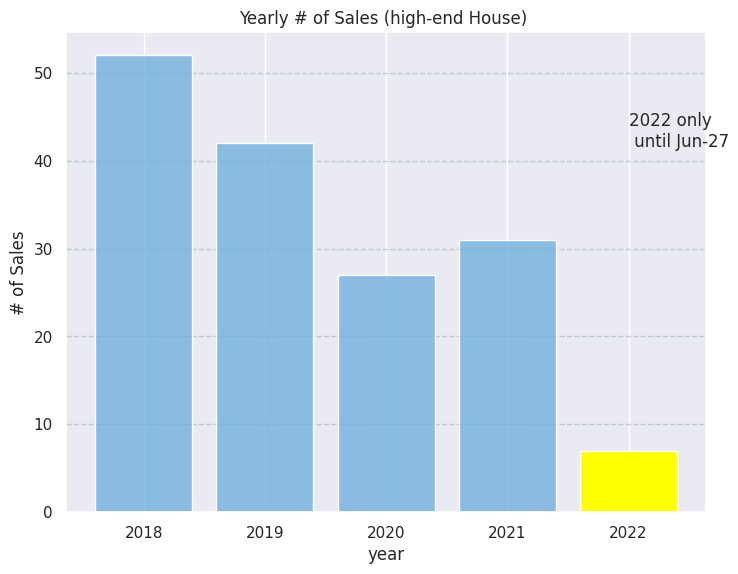

In [389]:
indicator = "nr_of_sales"
period = "year"
starting_year, final_year = 2018, 2022
location = "Bermuda"
property_type = "house"
bracket_dict = house_arv_brackets
bracket = "high-end" 

df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv") # import data
df = filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)

# display(df.to_frame())

<Figure size 800x500 with 0 Axes>

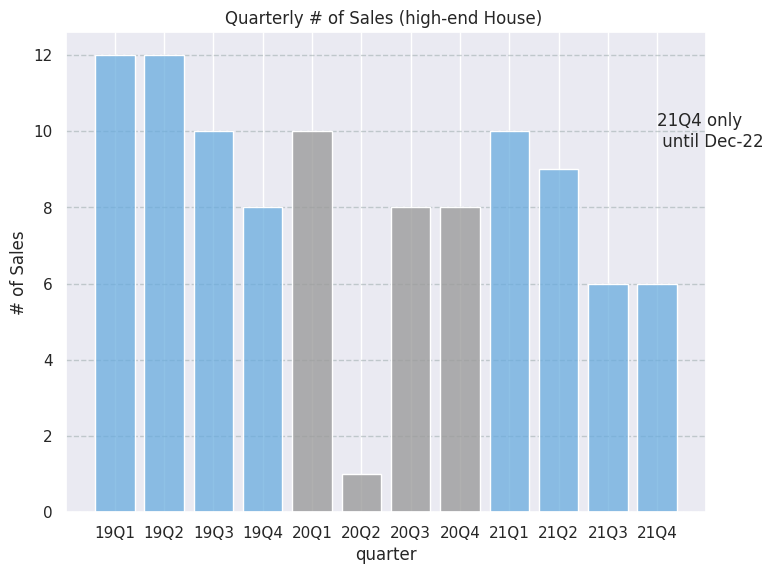

In [393]:
indicator = "nr_of_sales"
period = "quarter"
starting_year, final_year = 2019, 2021
location = "Bermuda"
property_type = "house"
bracket_dict = house_arv_brackets
bracket = "high-end" 

df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv") # import data
df = filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)

In [373]:
for x in range(df.shape[0]):
    print(x % 8)

0
1
2
3
4
5


In [384]:
my_colours = []
# nr_blocks_of_four = df.shape[0]/4
for x in range(df.shape[0]):
    if x%8 < 4:  # 
        my_colours.append(my_blue)
    else:
        my_colours.append(my_gray)

In [385]:
my_colours

[(0.41, 0.674, 0.87, 0.75),
 (0.41, 0.674, 0.87, 0.75),
 (0.41, 0.674, 0.87, 0.75),
 (0.41, 0.674, 0.87, 0.75),
 (0.41, 0.41, 0.41, 0.8),
 (0.41, 0.41, 0.41, 0.8)]

### Example 1.2: # of Year-over-Year sales volume in Bermuda

<Figure size 800x500 with 0 Axes>

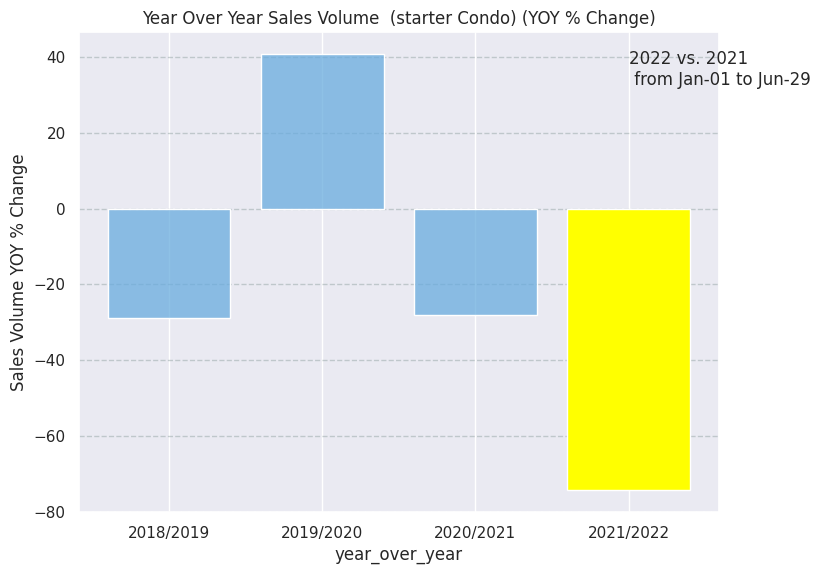

year
2019   -28.935702
2020    40.773597
2021   -28.055330
2022   -74.409989
Name: price, dtype: float64

In [247]:
indicator = "sales_volume"

starting_year, final_year = 2018, 2022
period = "year_over_year"
location = "Bermuda"
property_type = "condo"
bracket_dict = condo_arv_brackets
bracket = "starter"

df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv") # import data
filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)


### Example 1.2: Average sales prices for luxury condos, yearly in Bermuda

<Figure size 800x500 with 0 Axes>

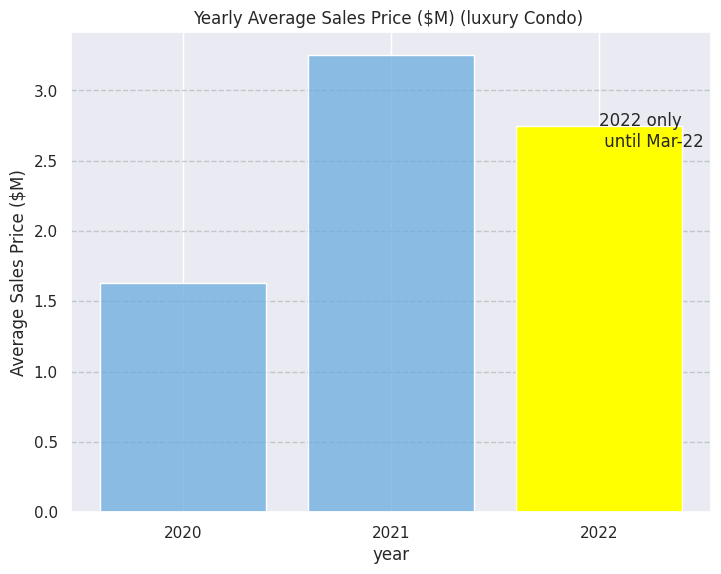

year
2020    1.630455
2021    3.251273
2022    2.743750
Name: price, dtype: float64

In [239]:
indicator = "average_sales_price"
starting_year, final_year = 2020, 2022
period = "year"
location = "Bermuda"
property_type = "condo"
bracket_dict = condo_arv_brackets
bracket = "luxury"

df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv") # import data
filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)

<Figure size 800x500 with 0 Axes>

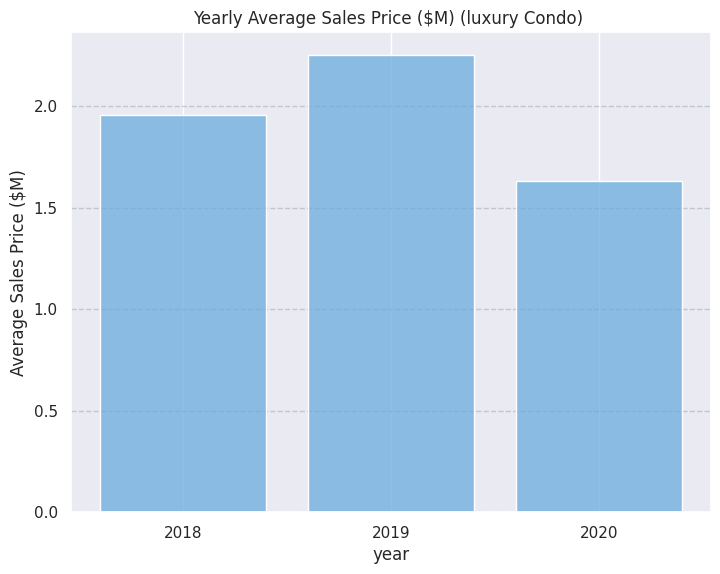

year
2018    1.955214
2019    2.252727
2020    1.630455
Name: price, dtype: float64

In [241]:
indicator = "average_sales_price"
starting_year, final_year = 2018, 2020
period = "year"
location = "Bermuda"
property_type = "condo"
bracket_dict = condo_arv_brackets
bracket = "luxury"

df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv") # import data
filter_and_graph(df, starting_year, final_year, property_type, 
                     bracket_dict, bracket, indicator, period, location)


# YTY Calculation

In [139]:
yty["by_year"] = df.copy()
yty["shifted"] = df.shift(periods=1, axis="rows")
yty["by_year"]/yty["shifted"]*100

In [146]:
yyy = [58994750, 329322326, 245519307, 242763630, 364234223]
# YTY_ratios: current_year/previous_year
YTY_ratios = [58994750/329322326*100, 329322326/245519307*100,245519307/242763630*100, 242763630/364234223*100 ]

YTY_ratios

[17.913984368007895, 134.13296494845514, 101.135127613638, 66.65041741560897]

# YOY Calculation

In [192]:
# (current_year - previous_year)/previous_year
YOY_ratios = [(58994750-329322326)/329322326*100, (329322326-245519307)/245519307, 
              (245519307-242763630)/242763630, (242763630-364234223)/364234223]
YOY_ratios

[-82.0860156319921,
 0.3413296494845515,
 0.011351276136380066,
 -0.33349582584391035]

In [228]:
indicator = "sales_volume"
period = "year_to_year"
location = "Bermuda"
property_type = "all"
house_price_bracket = None

df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv")
df = filter_property_type(df, property_type) # does not filter because property_type = all
df = filter_by_bracket(df, house_price_brackets, bracket=house_price_bracket) # does not filter, bracket=None

filtered_dataframe = df.groupby(["year"])["price"].agg(indicator_dict[indicator])
filtered_dataframe = filtered_dataframe.pct_change()*100

In [229]:
year_to_date = df["year"].max()

this_jan_string = f"{year_to_date}-01-01"
last_jan_string = f"{year_to_date-1}-01-01"

sales_this_year = df[df.index > this_jan_string]
last_sale_this_year = sales_this_year.index.max() 
last_sale_a_year_ago = f"{last_sale_this_year.year}-{last_sale_this_year.month}-{last_sale_this_year.day}"


sales_last_year = df[(df.index > last_jan_string) & (df.index < last_sale_a_year_ago)]

indicator_dict = {
        "nr_of_sales" : "count",
        "sales_volume": "sum",
        "median_sales_price": "median",
        "average_sales_price": "mean"
    }

indicator_to_today_last_year = sales_last_year.price.agg(indicator_dict["sales_volume"])
indicator_to_today = sales_this_year.price.agg(indicator_dict["sales_volume"])
indicator_to_today/indicator_to_today_last_year*100

15.226334719142065

### Example 2: Total Yearly sales volume for mid-market Condos

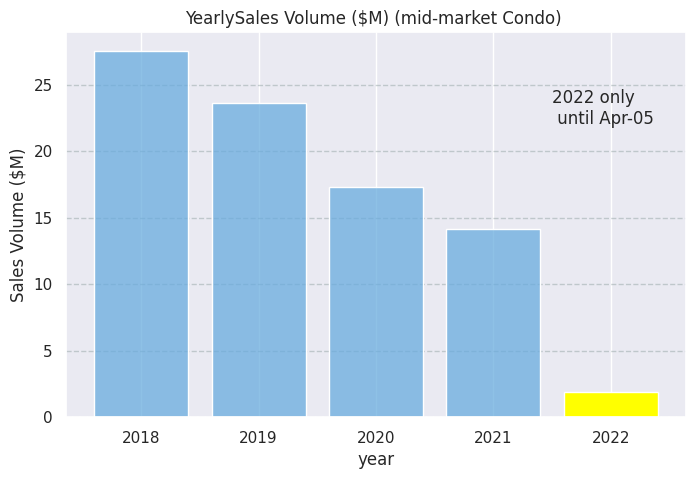

In [460]:
indicator = "sales_volume"
period = "year"
location = "Bermuda"
property_type = "condo"
bracket = "mid-market"

df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv") # import data
df = filter_property_type(df, property_type) # filter property type selected
df = filter_by_bracket(df, house_price_brackets, bracket) # filter by market segment
last_sale, df = filter_indicator_and_period(df, indicator, period) # filter and aggregate with indicator
my_title, my_ylabel = create_graph_labels(indicator, period, location, property_type, bracket) # generate label
create_bar_chart(df, last_sale, my_title, my_ylabel, period) # plot with disclaimer

In [461]:
df.index[-1]

2022

### Example 3: Average price of fractional Sales in Bermuda (Quarterly for 2020 - 2021)

In [454]:
indicators

['nr_of_sales', 'sales_volume', 'median_sales_price', 'average_sales_price']

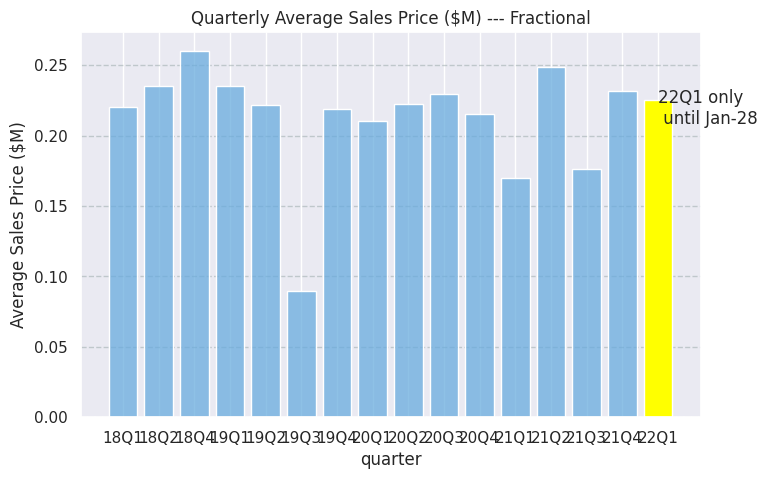

In [465]:
indicator = "average_sales_price"
# indicator = "nr_of_sales"
period = "quarter"
location = "Bermuda"
property_type = "fractional"
bracket = None # "mid-market"

df = rep.import_sales_data("./kw-data-import/data/kw-sales.csv") # import data
df = filter_property_type(df, property_type) # filter property type selected
df = filter_by_bracket(df, house_price_brackets, bracket) # filter by market segment
last_sale, df = filter_indicator_and_period(df, indicator, period) # filter and aggregate with indicator
my_title, my_ylabel = create_graph_labels(indicator, period, location, property_type, bracket) # generate label
create_bar_chart(df, last_sale, my_title, my_ylabel, period) # plot with disclaimer

In [20]:
xx = df.groupby('parish', as_index=False).agg({"price": "max", 'year':'first', 'quarter':'first'})
xx["price"] = xx["price"].map(rep.smtm)
xx

,parish,price,year,quarter
0,City of Hamilton,"$15,000,000",2018,Q1
1,Devonshire,"$3,250,000",2018,Q1
2,Hamilton,"$7,800,000",2018,Q1
3,Paget,"$13,000,000",2018,Q1
4,Pembroke,"$6,500,000",2018,Q1
5,Sandys,"$3,000,000",2018,Q1
6,Smiths,"$4,200,000",2018,Q1
7,Southampton,"$4,900,000",2018,Q1
8,St. George's,"$11,000,000",2018,Q1
9,Town of St. George,"$1,250,000",2018,Q1


In [65]:
xx = df.groupby('parish', as_index=False).agg({"combined_arv": "median", 'year':'last', 'quarter':'first'})
xx["combined_arv"] = xx["combined_arv"].map(rep.smtm)
xx

,parish,combined_arv,year,quarter
0,City of Hamilton,"$36,000",2022,Q1
1,Devonshire,"$35,100",2022,Q1
2,Hamilton,"$31,200",2022,Q1
3,Paget,"$57,600",2022,Q1
4,Pembroke,"$37,200",2022,Q1
5,Sandys,"$29,400",2022,Q1
6,Smiths,"$61,800",2022,Q1
7,Southampton,"$27,000",2022,Q1
8,St. George's,"$34,200",2022,Q1
9,Town of St. George,"$24,600",2021,Q1


In [67]:
western = ['Sandys', 'Southampton', 'Warwick']
central = ['Paget', 'City of Hamilton', 'Pembroke']
eastern = ['Devonshire', 'Smiths', 'Hamilton',"St. George's","Town of St. George"]
        
parish_region_dictionary = {v:'western' for v in western}
parish_region_dictionary.update({v:'central' for v in central})
parish_region_dictionary.update({v:'eastern' for v in eastern})
        
p_by_pa = df.groupby('parish', as_index=False).agg({"price": "mean", 
                                                    'combined_arv':'mean', })
#                                                     'year':'first', 
#                                                     'quarter':'first'})

p_by_pa

,parish,price,combined_arv
0,City of Hamilton,9.944535e+05,70748.514851
1,Devonshire,8.357246e+05,39150.000000
2,Hamilton,1.018578e+06,39679.720280
3,Paget,1.337629e+06,63255.797101
4,Pembroke,9.490334e+05,48024.060150
5,Sandys,5.950727e+05,33041.379310
6,Smiths,1.375465e+06,80675.423729
7,Southampton,8.048078e+05,36428.906250
8,St. George's,1.788343e+06,56104.545455
9,Town of St. George,4.078611e+05,24900.000000


In [69]:
p_by_pa['price'].groupby(p_by_pa['parish'].map(parish_region_dictionary)).agg("count") # .agg("count") # .map(rep.smtm)

parish
central    3
eastern    4
western    3
Name: price, dtype: int64

In [121]:
df.groupby(["year"])["price"].agg("median").apply(rep.smtm)

year
2018    $795,000
2019    $750,000
2020    $614,250
2021    $797,500
2022    $857,500
Name: price, dtype: object

In [115]:
df.groupby(['year'])['price'].agg(["sum","mean","median", "max", "min"]).style.format('${0:,.0f}')


,sum,mean,median,max,min
year,,,,,
2018,"$67,842,125","$1,884,503","$1,877,500","$2,450,000","$1,506,625"
2019,"$38,950,255","$1,947,513","$1,897,500","$2,400,000","$1,540,000"
2020,"$25,210,000","$1,939,231","$1,900,000","$2,500,000","$1,575,000"
2021,"$30,493,000","$1,793,706","$1,698,000","$2,400,000","$1,525,000"
2022,"$8,181,750","$2,045,438","$2,103,375","$2,225,000","$1,750,000"


### Example 1: Yearly #of sales

In [4]:
yearly_price_stats = df.groupby(['year'])['price'].agg(["sum","mean","median", "max", "min"]).style.format('${0:,.0f}')
yearly_price_stats # ["sum"].apply(smtm)

,sum,mean,median,max,min
year,,,,,
2018,"$364,234,223","$1,061,907","$795,000","$10,500,000","$12,000"
2019,"$242,763,630","$974,954","$750,000","$15,000,000","$13,500"
2020,"$245,519,307","$909,331","$614,250","$11,000,000","$10,000"
2021,"$329,322,326","$1,210,744","$797,500","$13,000,000","$13,800"
2022,"$58,994,750","$1,229,057","$857,500","$4,725,000","$225,000"


In [5]:
yearly_nr_sales = df.groupby(['year'])['price'].agg(["count"]) # ,"mean","median", "max", "min"])
yearly_nr_sales['yr'] = yearly_nr_sales.index


In [ ]:
yearly_nr_sales = df.groupby(['year'])['price'].agg(["count"]) # ,"mean","median", "max", "min"])
yearly_nr_sales['yr'] = yearly_nr_sales.index

In [77]:
volume_quarterly_sales = df.resample(rule='BQ')['price'].agg("sum")
volume_quarterly_sales['yr'] = volume_quarterly_sales.index.year
# volume_quarterly_sales['q'] = volume_quarterly_sales.index.quarter.map(lambda x: 'Q'+str(x))

# volume_quarterly_sales["quarter"] = volume_quarterly_sales.index.quarter
# volume_quarterly_sales['quarter'] = volume_quarterly_sales['quarter'].map(lambda x : 'Q'+str(x))
# volume_quarterly_sales['yr'] = volume_quarterly_sales.date

In [79]:
volume_quarterly_sales.index # .quarter.map(lambda x: 'Q'+str(x))

Index([2018-03-30 00:00:00, 2018-06-29 00:00:00, 2018-09-28 00:00:00,
       2018-12-31 00:00:00, 2019-03-29 00:00:00, 2019-06-28 00:00:00,
       2019-09-30 00:00:00, 2019-12-31 00:00:00, 2020-03-31 00:00:00,
       2020-06-30 00:00:00, 2020-09-30 00:00:00, 2020-12-31 00:00:00,
       2021-03-31 00:00:00, 2021-06-30 00:00:00, 2021-09-30 00:00:00,
       2021-12-31 00:00:00, 2022-03-31 00:00:00, 2022-06-30 00:00:00,
       2022-09-30 00:00:00,                'yr'],
      dtype='object', name='date')

In [ ]:
# Quarterly Sales
qs = tis.resample('BQ').sum()

# add a column describing which Quarter it is (for plotting)
qs['q'] = qs.index.quarter
qs['q'] = qs['q'].map(lambda x : 'Q'+str(x))

# add a column showing the year (for plotting)
qs['yr'] = qs.index.year